### 解約強度がステップ関数型の資産価格依存性を持つ場合の変額年金保険の最低保証に係る責任準備金評価式
### 第5章 数値計算例

### 必要なパッケージのインストール

In [1]:
import math
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import optimize
from pylab import rcParams
import matplotlib.font_manager
from matplotlib.ticker import PercentFormatter
import os

### 関数定義

In [2]:
def standard_benefit_pv(r, q, sigma, S, T, K):
    d_plus = (np.log(S/K) + (r-q + 0.5 * sigma * sigma) * T) / (sigma * np.sqrt(T))
    d_minus = d_plus - sigma * np.sqrt(T)
    return np.exp(- r * T) * K * norm.cdf(- d_minus) - np.exp(- q * T) * S * norm.cdf(- d_plus)

def standard_income_pv(q, S, T):
    return S * (1 - np.exp(- q * T))

def d_1(nu, k, x, T):
    return (-k +x + nu * T) / np.sqrt(T)

def d_3(nu, k, x, T):
    return (-k -x + nu * T) / np.sqrt(T)

def d_5(nu, k, x, t):
    return (-k -x + nu * t) / np.sqrt(t)

def d_7(nu, k, t):
    return (-k + nu * t) / np.sqrt(t)

def C_1(nu, x, T_minus_t):
    return 1 - x * x / (T_minus_t) - nu * x;

def C_2(nu, k, x, t, T_minus_t):
    return C_1(nu, x, T_minus_t) / np.sqrt(t) - x * k / (t * np.sqrt(t))

def psi_1_integrand(rho, nu, k, x, T, s): 
    t = 0.5 * T * ( np.exp(0.5 * math.pi * np.sinh(s)) / np.cosh(0.5 * math.pi * np.sinh(s)))
    T_minus_t =  0.5 * T * (np.exp( - 0.5 * math.pi * np.sinh(s)) / np.cosh(0.5 * math.pi * np.sinh(s)))

    d_5_ = d_5(nu, k, x, t)
    jacobian = 0.25 * math.pi * T * np.cosh(s)/ pow(np.cosh(0.5 * math.pi * np.sinh(s)) , 2)
    integrand = (1 - np.exp(-rho * (T_minus_t))) * np.exp(0.5 * nu * nu * t) \
                / ( math.sqrt(2 * math.pi) * rho * pow(T_minus_t, 1.5) ) \
                * (nu * norm.cdf(d_5_) + norm.pdf(d_5_) / np.sqrt(t) )
    return integrand * jacobian

def psi_2_integrand(rho, nu, k, x, T, s):
    t = 0.5 * T * ( np.exp(0.5 * math.pi * np.sinh(s)) / np.cosh(0.5 * math.pi * np.sinh(s)))
    T_minus_t =  0.5 * T * (np.exp( - 0.5 * math.pi * np.sinh(s)) / np.cosh(0.5 * math.pi * np.sinh(s)))

    d_7_ = d_7(nu, k, t)
    jacobian = 0.25 * math.pi * T * np.cosh(s) / pow(np.cosh(0.5 * math.pi * np.sinh(s)) , 2)
    integrand = (1 - np.exp(-rho * (T_minus_t))) \
                * np.exp(0.5 * nu * nu * t) \
                / ( math.sqrt(2 * math.pi) * rho * pow(T_minus_t, 1.5) ) \
                * (nu * C_1(nu, x, T_minus_t) * norm.cdf(d_7_) + C_2(nu, k, x, t, T_minus_t) * norm.pdf(d_7_) ) \
                * np.exp(- 0.5 * x * x / (T_minus_t) ) 
    return integrand * jacobian

def psi_1(rho, nu, k, x, T, 
          upper_trunc_DE, lower_trunc_DE, grid_num_DE):
    s = np.linspace(lower_trunc_DE, upper_trunc_DE, grid_num_DE + 1)
    integrand = psi_1_integrand(rho, nu, k, x, T, s)
    ds = (upper_trunc_DE - lower_trunc_DE) / grid_num_DE
    integral = np.sum(integrand) * ds
    return np.exp(nu * x + 0.5 * nu * nu * T) * norm.cdf(d_1(nu, k, x, T)) \
            - np.exp(- nu * x + 0.5 * nu * nu * T) * norm.cdf(d_3(nu, k, x, T)) \
            + np.exp(- nu * x) * integral

def psi_2(rho, nu, k, x, T, 
          upper_trunc_DE, lower_trunc_DE, grid_num_DE):
    s = np.linspace(lower_trunc_DE, upper_trunc_DE, grid_num_DE + 1)
    integrand = psi_2_integrand(rho, nu, k, x, T, s)
    ds = (upper_trunc_DE - lower_trunc_DE) / grid_num_DE
    integral = np.sum(integrand) * ds
    return integral

def psi_3(rho, nu, k, x, T,
          epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE):
    psi_1_val   = psi_1( rho,  nu,       0.0,  x, T, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    psi_2_val_1 = psi_2(-rho, -nu, epsilon_k, -x, T, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    psi_2_val_2 = psi_2(-rho, -nu,        -k, -x, T, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    return psi_1_val + np.exp(-rho * T) * (psi_2_val_1 - psi_2_val_2)

def psi_4(rho, nu, k, x, T, 
          epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE):
    psi_2_val   = psi_2( rho,  nu, epsilon_k,  x, T, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    psi_1_val_1 = psi_1(-rho, -nu,       0.0, -x, T, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    psi_1_val_2 = psi_1(-rho, -nu,        -k, -x, T, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    return psi_2_val + np.exp(-rho * T) * (psi_1_val_1 - psi_1_val_2)

def psi(rho, nu, k, x, T, epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE): 
    if k >= 0 and x >= 0:
        return psi_1(rho, nu, k, x, T, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    elif k >= 0 and x < 0:
        return psi_2(rho, nu, k, x, T, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    elif k < 0 and x >= 0:
        return psi_3(rho, nu, k, x, T, epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    else:
        return psi_4(rho, nu, k, x, T, epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE)

def benefit_pv(r, q, sigma, rho, S, T, K, B, 
               epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE):
    nu = (r - q - 0.5 * sigma**2) / sigma
    gamma = r + 0.5 * nu * nu
    x = np.log(S/B) / sigma
    k = np.log(K/B) / sigma
    psi_val_1 = psi(rho,         -nu, -k, -x, T, epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    psi_val_2 = psi(rho, -(nu+sigma), -k, -x, T, epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    return np.exp(- gamma * T - nu * x) * (K *  psi_val_1 - B * psi_val_2)

def psi_3_k_neginf(rho, nu, x, T, 
                   epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE):
    psi_1_val = psi_1( rho,  nu,       0.0,  x, T, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    psi_2_val = psi_2(-rho, -nu, epsilon_k, -x, T, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    return psi_1_val + np.exp(-rho * T) * psi_2_val

def psi_4_k_neginf(rho, nu, x, T, 
                   epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE):
    psi_2_val = psi_2( rho,  nu, epsilon_k,  x, T, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    psi_1_val = psi_1(-rho, -nu,       0.0, -x, T, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    return psi_2_val + np.exp(-rho * T) * psi_1_val

def psi_k_neginf(rho, nu, x, T, 
                 epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE): 
    if x >= 0:
        return psi_3_k_neginf(rho, nu, x, T, epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    else:
        return psi_4_k_neginf(rho, nu, x, T, epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE)

def income_pv_integrand(r, q, sigma, rho, S, t, B, 
                        epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE):
    if t == 0:
        return S / B
    else:
        nu = (r - q - 0.5 * sigma**2) / sigma
        gamma = r + 0.5 * nu * nu
        x = np.log(S/B) / sigma
        psi_val = psi_k_neginf(rho, -(nu+sigma), -x, t, epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
        return np.exp(- gamma * t - nu * x) * psi_val

def income_pv(r, q, sigma, rho, S, T, B, 
              epsilon_k, grid_num_income,
              upper_trunc_DE, lower_trunc_DE, grid_num_DE):
    t_array = np.linspace(0, T, grid_num_income + 1)
    income_pv_integrand_vec = np.vectorize(income_pv_integrand)
    integrand = income_pv_integrand_vec(r, q, sigma, rho, S, t_array, B, epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    return q * B * np.trapz(integrand, dx = T / grid_num_income)

### 5.1節: (下準備) 解約を考慮しないときの最低保証費用率

In [3]:
r = 0.01
sigma = 0.05
S = 100
T = 10
K = 100

q_no_lapse = optimize.newton(lambda x: standard_benefit_pv(r, x, sigma, S, T, K) - standard_income_pv(x, S, T), x0 = 0.0)

print("解約を考慮しないときの最低保証費用率: ", q_no_lapse)
benefit_pv_no_lapse = standard_benefit_pv(r, q_no_lapse, sigma, S, T, K)
print("解約を考慮しないときの給付現価: ", benefit_pv_no_lapse)
income_pv_no_lapse = standard_income_pv(q_no_lapse, S, T)
print("解約を考慮しないときの収入現価: ", income_pv_no_lapse)

解約を考慮しないときの最低保証費用率:  0.003357508767368868
解約を考慮しないときの給付現価:  3.301769994607451
解約を考慮しないときの収入現価:  3.3017699946074397


### 5.1節: 計算前提

In [4]:
r = 0.01
q = q_no_lapse
sigma = 0.05
rho = - np.log(0.90)
S = 100
T = 10
K = 100

epsilon_k = 0.0001
grid_num_income = 20
upper_trunc_DE = 4.0
lower_trunc_DE = -4.0
grid_num_DE = 200

B_array = np.arange(70, 130 + 1)

### 5.1節: 計算実行

In [5]:
#%%time

benefit_pv_vec = np.vectorize(benefit_pv)
benefit_pv_values = benefit_pv_vec(r, q, sigma, rho, S, T, K, B_array, 
                                   epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE)

income_pv_vec = np.vectorize(income_pv)
income_pv_values = income_pv_vec(r, q, sigma, rho, S, T, B_array, 
                                 epsilon_k, grid_num_income,
                                 upper_trunc_DE, lower_trunc_DE, grid_num_DE)

reserve_values = benefit_pv_values - income_pv_values

### 5.1節: グラフ作成

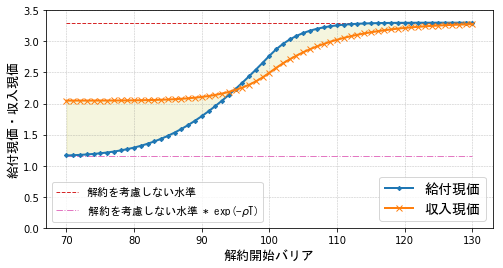

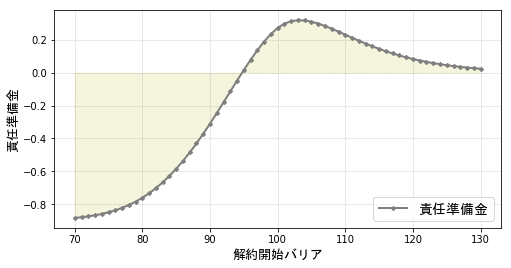

In [6]:
rcParams['figure.figsize'] = 8, 4

fontprop = matplotlib.font_manager.FontProperties(fname="C:/Windows/Fonts/msgothic.ttc")
fontprop11 = matplotlib.font_manager.FontProperties(fname="C:/Windows/Fonts/msgothic.ttc", size=11)
fontprop14 = matplotlib.font_manager.FontProperties(fname="C:/Windows/Fonts/msgothic.ttc", size=14)

main1, = plt.plot(B_array, benefit_pv_values, linestyle = "-", label='給付現価', linewidth = 2,
                  marker="D", markersize=3)
main2, = plt.plot(B_array, income_pv_values, linestyle = "-", label='収入現価', linewidth = 2,
                  marker="x", markersize=6)
main_list = [main1, main2]

cmap = plt.get_cmap("tab10") 
sub1 = plt.hlines([benefit_pv_no_lapse], 70, 130, color = cmap(3), linestyles="--", 
                  label = "解約を考慮しない水準", linewidth = 1)
sub2 = plt.hlines([benefit_pv_no_lapse * np.exp(-rho*T)], 70, 130, color = cmap(6), linestyles="-.", 
                  label = r"解約を考慮しない水準 * exp(-$\rho$T)", linewidth = 1)
sub_list = [sub1, sub2]

main_label = [ g.get_label() for g in main_list]
sub_label = [ g.get_label() for g in sub_list]
main_legend = plt.legend(main_list, main_label, loc='lower right', prop=fontprop14)
sub_legend = plt.legend(sub_list, sub_label, loc='lower left', prop=fontprop11)
plt.gca().add_artist(main_legend) 

plt.fill_between(B_array, income_pv_values, benefit_pv_values, facecolor='y', alpha=0.15, color = cmap(8))

plt.xlabel("解約開始バリア", fontsize=13, fontdict = {"fontproperties": fontprop})
plt.ylabel("給付現価・収入現価", fontsize=13, fontdict = {"fontproperties": fontprop})
plt.ylim([0, 3.5])
plt.grid(which = "major", axis = "x", color = "gray", alpha = 0.5, linestyle = "--", linewidth = 0.5)
plt.grid(which = "major", axis = "y", color = "gray", alpha = 0.5, linestyle = "--", linewidth = 0.5)

os.makedirs('figure_chapter_5', exist_ok=True) 
plt.savefig('figure_chapter_5/benefit_and_income_vs_B.png', bbox_inches="tight")
plt.show()

plt.plot(B_array, reserve_values, linestyle = "-", color = cmap(7), label='責任準備金', linewidth = 2,
                  marker="D", markersize=3)
zeros = np.zeros(len(B_array))
plt.fill_between(B_array, zeros, reserve_values, facecolor='y', alpha=0.15, color = cmap(8))

plt.grid(which = "major", axis = "x", color = "gray", alpha = 0.5, linestyle = "--", linewidth = 0.5)
plt.grid(which = "major", axis = "y", color = "gray", alpha = 0.5, linestyle = "--", linewidth = 0.5)

plt.xlabel("解約開始バリア", fontsize=13, fontdict = {"fontproperties": fontprop})
plt.ylabel("責任準備金", fontsize=13, fontdict = {"fontproperties": fontprop})
plt.legend(loc='lower right', prop=fontprop14)

plt.savefig('figure_chapter_5/reserve_vs_B.png', bbox_inches="tight")
plt.show()

### 5.2節: 計算前提

In [7]:
r = 0.01
sigma = 0.05
rho = - np.log(0.90)
S = 100
T = 10
K = 100

epsilon_k = 0.0001
grid_num_income = 20
upper_trunc_DE = 4.0
lower_trunc_DE = -4.0
grid_num_DE = 200

B_array = np.arange(70, 130 + 1)

### 5.2節: 計算実行

In [8]:
#%%time
q_of_B = [optimize.newton(lambda x: benefit_pv(r, x, sigma, rho, S, T, K, B_array[i], 
                                               epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE) \
                                    - income_pv(r, x, sigma, rho, S, T, B_array[i], 
                                                epsilon_k, grid_num_income,
                                                upper_trunc_DE, lower_trunc_DE, grid_num_DE),
                          x0 = 0.0)
          for i in range(0, len(B_array))]

### 5.2節: グラフ作成

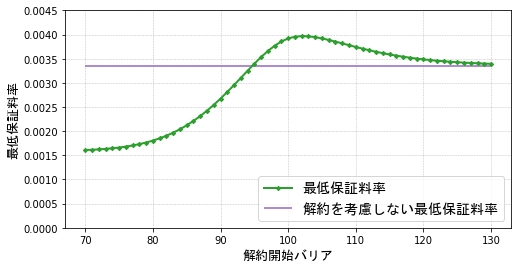

In [9]:
rcParams['figure.figsize'] = 8, 4
cmap = plt.get_cmap("tab10") 
fontprop = matplotlib.font_manager.FontProperties(fname="C:/Windows/Fonts/msgothic.ttc")
fontprop14 = matplotlib.font_manager.FontProperties(fname="C:/Windows/Fonts/msgothic.ttc", size=14)

plt.plot(B_array, q_of_B, linestyle = "-", color = cmap(2), label='最低保証料率', linewidth = 2, marker="D", markersize=3)
plt.ylim([0, 0.0045])
plt.hlines([q_no_lapse], 70, 130, color = cmap(4), linestyles="-", 
                  label = "解約を考慮しない最低保証料率", linewidth = 1.5)

plt.grid(which = "major", axis = "x", color = "gray", alpha = 0.5, linestyle = "--", linewidth = 0.5)
plt.grid(which = "major", axis = "y", color = "gray", alpha = 0.5, linestyle = "--", linewidth = 0.5)

plt.xlabel("解約開始バリア", fontsize=13, fontdict = {"fontproperties": fontprop})
plt.ylabel("最低保証料率", fontsize=13, fontdict = {"fontproperties": fontprop})
plt.legend(loc='lower right', fontsize=14, prop = fontprop14)
os.makedirs('figure_chapter_5', exist_ok=True)
plt.savefig('figure_chapter_5/premium_vs_B.png')
plt.show()

### 5.3節: 計算前提

In [10]:
r = 0.01
sigma = 0.05
lapse_rate = np.linspace(0.01, 0.15, 15)
rho_array = - np.log(1 - lapse_rate)
B = 100
S = 100
T = 10
K = 100

epsilon_k = 0.0001
grid_num_income = 20
upper_trunc_DE = 4.0
lower_trunc_DE = -4.0
grid_num_DE = 200

### 5.3節: 計算実行

In [11]:
#%%time
q_of_rho = [optimize.newton(lambda x: benefit_pv(r, x, sigma, rho_array[i], S, T, K, B, 
                                                 epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE) \
                                      - income_pv(r, x, sigma, rho_array[i], S, T, B, 
                                                  epsilon_k, grid_num_income,
                                                  upper_trunc_DE, lower_trunc_DE, grid_num_DE),
                           x0 = 0.0)
           for i in range(0, len(rho_array))]
q_of_rho = np.hstack((np.array([q_no_lapse]), q_of_rho))
increase_rate = q_of_rho/q_no_lapse - 1

### 5.3節: グラフ作成

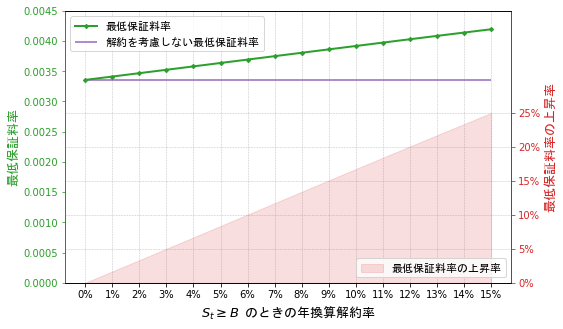

In [12]:
rcParams['figure.figsize'] = 8, 5
cmap = plt.get_cmap("tab10") 
fontprop = matplotlib.font_manager.FontProperties(fname="C:/Windows/Fonts/msgothic.ttc")
fontprop11 = matplotlib.font_manager.FontProperties(fname="C:/Windows/Fonts/msgothic.ttc", size=11)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ln1 = ax1.plot(np.linspace(0.0, 0.15, 15 + 1), q_of_rho, linestyle = "-", color = cmap(2), label='最低保証料率', linewidth = 2,
               marker="D", markersize=3)
ax1.set_ylim([0, 0.0045])
ax1.hlines([q_no_lapse], 0, 0.15, color = cmap(4), linestyles="-", 
           label = "解約を考慮しない最低保証料率", linewidth = 1.5)

ax2 = ax1.twinx()
zeros = np.zeros(16)
ln2 = ax2.fill_between(np.linspace(0.0, 0.15, 15 + 1), zeros, increase_rate, facecolor='y', alpha=0.15, color = cmap(3), 
                       label="最低保証料率の上昇率")
ax2.set_ylim([0, 0.40])

ax2.xaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))
ax2.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1, l1, loc='upper left', prop=fontprop11)

ax1.set_xlabel('$S_t \geq B$ のときの年換算解約率', fontsize=13, fontdict = {"fontproperties": fontprop})
ax1.set_ylabel('最低保証料率', fontsize=13, color=cmap(2), fontdict = {"fontproperties": fontprop})
ax1.tick_params(axis='y', colors=cmap(2))

ax2.set_ylabel('最低保証料率の上昇率', fontsize=13, color=cmap(3), fontdict = {"fontproperties": fontprop})
ax2.tick_params(axis='y', colors=cmap(3))
ax2.spines['left'].set_color(cmap(2))
ax2.spines['right'].set_color(cmap(3))

ax2.set_xticks(np.arange(0, 0.16, 0.01))
ax2.set_yticks(np.arange(0, 0.30, 0.05))

ax1.grid(which = "major", axis = "x", color = "gray", alpha = 0.5, linestyle = "--", linewidth = 0.5)
ax2.grid(which = "major", axis = "y", color = "gray", alpha = 0.5, linestyle = "--", linewidth = 0.5)

ax2.legend(loc='lower right', prop=fontprop11)

os.makedirs('figure_chapter_5', exist_ok=True)
plt.savefig('figure_chapter_5/premium_vs_rho.png')
plt.show()